![Py4Eng](img/logo.png)

# Requests: HTTP for Humans
## Yoav Ram

In this session we'll learn to use the [requests](docs.python-requests.org/) package to easily send HTTP requests.
Install, if not already installed, with `pip install requests`.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import requests
import pandas as pd
import io
import seaborn as sns
sns.set_style('white')
sns.set_context('talk', font_scale=1.3)

`requests` allows us to communicate with web APIs. 

For example, we'll use the [World Bank Climate API](http://data.worldbank.org/developers/climate-data-api) to get some data and plot it.

The Climate API works like this:
```
https://api.worldbank.org/v2/country/{country}/indicator/{indicator}?date={start}:{end}&downloadformat=csv
```
- `country` is a country code
- `indicator` is the variable we want to get
- `start` and `end` are years, corresponding to specific ranges (see docs)
- `format` is the data format, we will use `json`.

Let's get the total population size in Israel between 1980 and 1999.

In [55]:
base_url = 'https://api.worldbank.org/v2/country/{country}/indicator/{indicator}?date={start}:{end}&format=json'
url = base_url.format(
    country='isr',
    indicator='SP.POP.TOTL', 
    start='1960', 
    end='2023'
)
print(url)

https://api.worldbank.org/v2/country/isr/indicator/SP.POP.TOTL?date=1960:2023&format=json


You can click the URL to verify that it is valid.

Now we `requests.get` to get the data at the URL, and check that it returned ok:

In [56]:
r = requests.get(url)
r.ok

True

The data is in json, which requests automatically parses:

In [57]:
print(r.json())

[{'page': 1, 'pages': 2, 'per_page': 50, 'total': 64, 'sourceid': '2', 'lastupdated': '2025-10-07'}, [{'indicator': {'id': 'SP.POP.TOTL', 'value': 'Population, total'}, 'country': {'id': 'IL', 'value': 'Israel'}, 'countryiso3code': 'ISR', 'date': '2023', 'value': 9849000, 'unit': '', 'obs_status': '', 'decimal': 0}, {'indicator': {'id': 'SP.POP.TOTL', 'value': 'Population, total'}, 'country': {'id': 'IL', 'value': 'Israel'}, 'countryiso3code': 'ISR', 'date': '2022', 'value': 9557500, 'unit': '', 'obs_status': '', 'decimal': 0}, {'indicator': {'id': 'SP.POP.TOTL', 'value': 'Population, total'}, 'country': {'id': 'IL', 'value': 'Israel'}, 'countryiso3code': 'ISR', 'date': '2021', 'value': 9371400, 'unit': '', 'obs_status': '', 'decimal': 0}, {'indicator': {'id': 'SP.POP.TOTL', 'value': 'Population, total'}, 'country': {'id': 'IL', 'value': 'Israel'}, 'countryiso3code': 'ISR', 'date': '2020', 'value': 9215100, 'unit': '', 'obs_status': '', 'decimal': 0}, {'indicator': {'id': 'SP.POP.TOTL'

But actually we'd like to load it into a data frame:

In [58]:
data = pd.json_normalize(r.json()[1])
data['date'] = pd.to_datetime(data['date'], format='%Y')
data.head()

,countryiso3code,date,value,unit,obs_status,decimal,indicator.id,indicator.value,country.id,country.value
0,ISR,2023-01-01,9849000,,,0,SP.POP.TOTL,"Population, total",IL,Israel
1,ISR,2022-01-01,9557500,,,0,SP.POP.TOTL,"Population, total",IL,Israel
2,ISR,2021-01-01,9371400,,,0,SP.POP.TOTL,"Population, total",IL,Israel
3,ISR,2020-01-01,9215100,,,0,SP.POP.TOTL,"Population, total",IL,Israel
4,ISR,2019-01-01,9054000,,,0,SP.POP.TOTL,"Population, total",IL,Israel


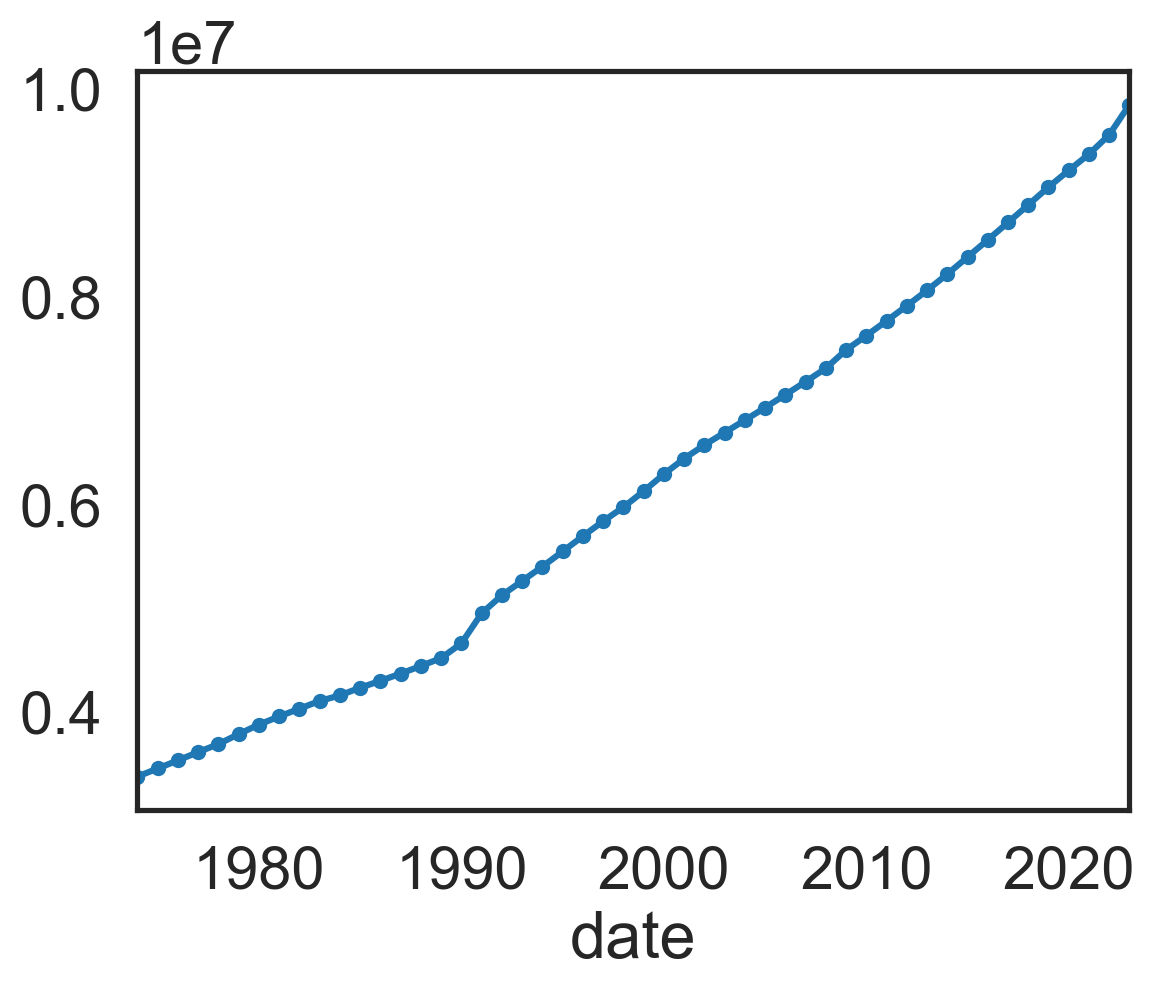

In [60]:
data.plot(x='date', y='value', marker='.')
plt.legend().set_visible(False);

## Stack exchange API

Next, we connect to the [Stack exchange API](https://api.stackexchange.com/docs/tags) to find the most popular tags.

Let's get the 10 most popular tags on stackoverflow - sort by populat, descending order, and limit response to 10 items:

In [61]:
base_url = "https://api.stackexchange.com"
query = "/2.2/tags?page=1&pagesize=60&order=desc&sort=popular&site=stackoverflow"

r = requests.get(base_url + query)
r.ok

True

Here the response is in JSON format, which requests parses for us using the `json` function:

In [62]:
data = r.json()
data.keys()

dict_keys(['items', 'has_more', 'quota_max', 'quota_remaining'])

In [63]:
data['items'][:5]

[{'has_synonyms': True,
  'is_moderator_only': False,
  'is_required': False,
  'count': 2534446,
  'name': 'javascript'},
 {'has_synonyms': True,
  'is_moderator_only': False,
  'is_required': False,
  'count': 2222090,
  'name': 'python'},
 {'has_synonyms': True,
  'is_moderator_only': False,
  'is_required': False,
  'count': 1923554,
  'name': 'java'},
 {'has_synonyms': True,
  'is_moderator_only': False,
  'is_required': False,
  'count': 1627540,
  'name': 'c#'},
 {'has_synonyms': True,
  'is_moderator_only': False,
  'is_required': False,
  'count': 1467225,
  'name': 'php'}]

The `items` member of the response can be given to pandas to create a data frame:

In [64]:
df = pd.DataFrame(r.json()['items'])
df.head()

,has_synonyms,is_moderator_only,is_required,count,name
0,True,False,False,2534446,javascript
1,True,False,False,2222090,python
2,True,False,False,1923554,java
3,True,False,False,1627540,c#
4,True,False,False,1467225,php


Let's see the rank of C and Python in the list:

In [66]:
for i, d in enumerate(data['items']):
    if d['name']=='c': print('C: {}'.format(i))
    if d['name']=='python': print('Python: {}'.format(i))

Python: 1
C: 17


Now let's take only the first 10:

In [67]:
df = (df[:10])
df.sort_values('count', ascending=False, inplace=True)
df

,has_synonyms,is_moderator_only,is_required,count,name
0,True,False,False,2534446,javascript
1,True,False,False,2222090,python
2,True,False,False,1923554,java
3,True,False,False,1627540,c#
4,True,False,False,1467225,php
5,True,False,False,1420353,android
6,True,False,False,1190799,html
7,True,False,False,1032012,jquery
8,True,False,False,818093,c++
9,True,False,False,809473,css


We find the indexes for `python`, `c#`, and `java` in the `name` column in which 

In [70]:
names = df.name.tolist()
python_idx = names.index('python')
matlab_idx = names.index('c#')
r_idx = names.index('java')
python_idx, matlab_idx, r_idx

(1, 3, 2)

Finally, we plot a bat plot of the counts, and highlight the python bar by coloring it:

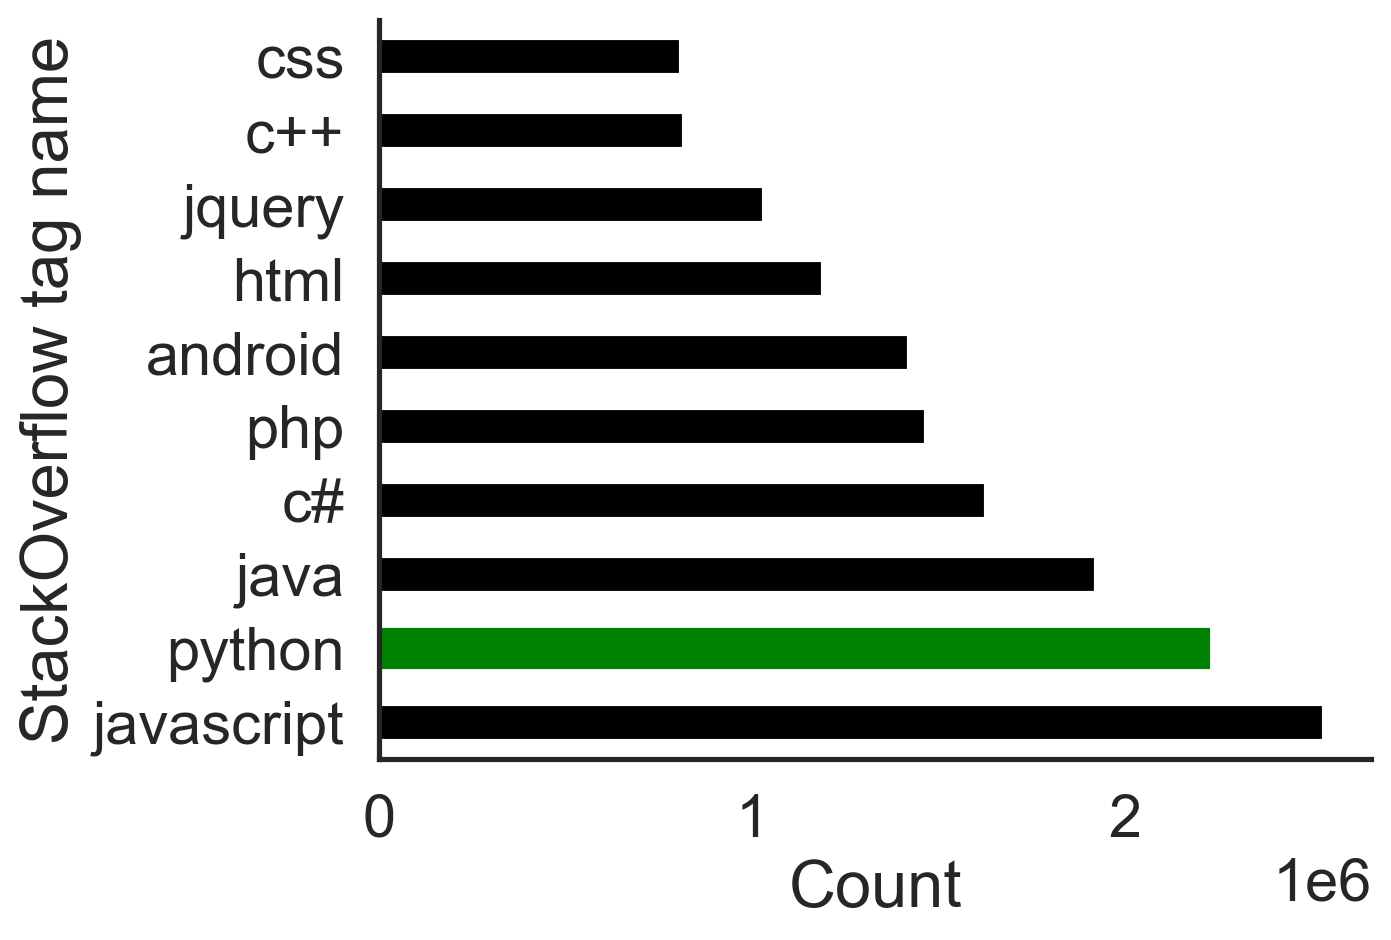

In [71]:
ax = df.plot.barh('name', 'count', color='k')
patches, labels = ax.get_legend_handles_labels()
patches[0][python_idx].set_color('green')
plt.ylabel('StackOverflow tag name')
plt.xlabel('Count')
plt.legend().set_visible(False)
sns.despine()

## Exercise

Create a data frame for the matlab, numpy, scipy, and matplotlib-tagged questions, sort by `count`, and plot a bar plot to compare their counts.

See [solution code](https://github.com/yoavram/Py4Eng/blob/master/solutions/requests-sof.py).

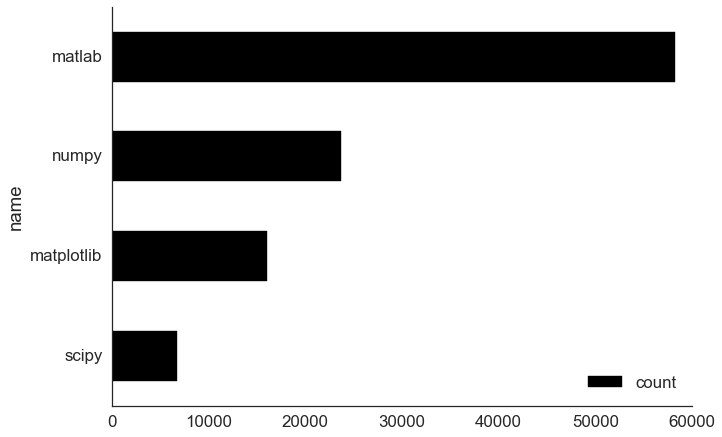

## Colophon
This notebook was written by [Yoav Ram](http://python.yoavram.com)

This work is licensed under a CC BY-NC-SA 4.0 International License.

![Python logo](https://www.python.org/static/community_logos/python-logo.png)